# Paper plots and statistics - main text

This notebook contains the plots and statistics that made their way into the main text of the final peper.

## Setup

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from cycler import cycler

plt.style.use(["ggplot", "icm.mplstyle"])

style_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
source_file = "review_final.csv"
source_path = os.path.join("data", source_file)
papers_df = pd.read_csv(source_path)
papers_df.drop(
    columns=["Comments (enter 'N/A' if none)", "Title.1"], inplace=True
)

## Numbers / stats

In [3]:
n_papers = papers_df.shape[0]
print(f"Total number of papers: {n_papers}")

learning_types = [
    "Supervised learning", "Unsupervised learning",
    "Reinforcement learning", "Biological / physiological model"
]
print()
print("Papers per algotithm type: ")
print(pd.DataFrame({
    "Total": papers_df[learning_types].sum(),
    "(%)": papers_df[learning_types].sum() / n_papers*100,
}))

print()
print("Papers using MIMIC (any version): ")
print(pd.DataFrame({
    "Total": [papers_df[papers_df[lt]]["MIMIC (any version)"].sum() for lt in learning_types],
    "(%)": [100 * papers_df[papers_df[lt]]["MIMIC (any version)"].sum() / papers_df[lt].sum() for lt in learning_types],
}, index=learning_types))
print(f"Overall: {papers_df['MIMIC (any version)'].sum()}, {100*papers_df['MIMIC (any version)'].sum()/papers_df.shape[0]} %")

print()
print("Papers with internal validation: ")
print(pd.DataFrame({
    "Total": [papers_df[papers_df[lt]]["Internal validation"].sum() for lt in learning_types],
    "(%)": [100 * papers_df[papers_df[lt]]["Internal validation"].sum() / papers_df[lt].sum() for lt in learning_types],
}, index=learning_types))
print(f"Overall: {papers_df['Internal validation'].sum()}, {100*papers_df['Internal validation'].sum()/papers_df.shape[0]} %")

external_validations = [
    "External retrospective validation (other hospitals)",
    "External retrospective validation (separate dataset)",
]
print()
print("Papers with External retrospective validation: ")
print(pd.DataFrame({
    "Total": [papers_df[papers_df[lt]][external_validations].max(axis=1).sum() for lt in learning_types],
    "(%)": [100 * papers_df[papers_df[lt]][external_validations].max(axis=1).sum() / papers_df[lt].sum() for lt in learning_types],
}, index=learning_types))
print(f"Overall: {papers_df[external_validations].max(axis=1).sum()}, {100*papers_df[external_validations].max(axis=1).sum()/papers_df.shape[0]} %")

print()
prospective_validations = [
    "Prospective observational validation",
    "Non-randomised interventional validation (clinical trial)",
    "Randomised interventional validation (clinical trial)",
    "Post-deployment surveillance"
]
print("Papers with prospective validation: ")
print(pd.DataFrame({
    "Total": [papers_df[papers_df[lt]][prospective_validations].max(axis=1).sum() for lt in learning_types],
    "(%)": [100 * papers_df[papers_df[lt]][prospective_validations].max(axis=1).sum() / papers_df[lt].sum() for lt in learning_types],
}, index=learning_types))
print(f"Overall: {papers_df[prospective_validations].max(axis=1).sum()}, {100*papers_df[prospective_validations].max(axis=1).sum()/papers_df.shape[0]} %")

print()
n_last_5_years = (papers_df["Year of publication"] > 2016).sum()
n_before_2010 = (papers_df["Year of publication"] < 2010).sum()
print(f"Number of papers in the last 5 yeas: {n_last_5_years} ({100 * n_last_5_years / n_papers:.1f} %)")
print(f"Number of papers before 2010: {n_before_2010} ({100 * n_before_2010 / n_papers:.1f} %)")

print()
print("Number of patient episodes:")
tmp_df = papers_df[papers_df["Number of patient episodes is specified"]]
print(pd.DataFrame({
    "Overall": tmp_df["Total number of patient episodes"].dropna().apply(lambda x: float(x.replace(",", ""))).describe(percentiles=[0.25, 0.75]),
} | {
    lt: tmp_df[tmp_df[lt]]["Total number of patient episodes"].dropna().apply(lambda x: float(x.replace(",", ""))).describe(percentiles=[0.25, 0.75]) for lt in learning_types
}))

print()
n_clinical_trials = (papers_df["Randomised interventional validation (clinical trial)"]).sum()
n_patients_in_trial = papers_df[papers_df["Randomised interventional validation (clinical trial)"]]["Total number of patient episodes"].item()
print(f"There is {n_clinical_trials} clinical trial paper, inclusing {n_patients_in_trial} patients.")

Total number of papers: 73

Papers per algotithm type: 
                                  Total        (%)
Supervised learning                  55  75.342466
Unsupervised learning                 8  10.958904
Reinforcement learning               26  35.616438
Biological / physiological model      4   5.479452

Papers using MIMIC (any version): 
                                  Total        (%)
Supervised learning                  31  56.363636
Unsupervised learning                 5  62.500000
Reinforcement learning               22  84.615385
Biological / physiological model      2  50.000000
Overall: 46, 63.013698630136986 %

Papers with internal validation: 
                                  Total        (%)
Supervised learning                  45  81.818182
Unsupervised learning                 5  62.500000
Reinforcement learning               23  88.461538
Biological / physiological model      2  50.000000
Overall: 59, 80.82191780821918 %

Papers with External retrospective valid

In [4]:
papers_df.to_excel('./data/res.xlsx')
print('done')

ModuleNotFoundError: No module named 'openpyxl'

## Plots

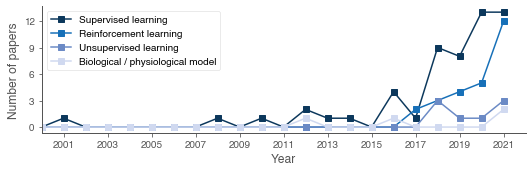

In [7]:
learning_types = [
    "Supervised learning",  "Reinforcement learning",
    "Unsupervised learning", "Biological / physiological model"
]
year_min = 2_000
tmp_df = papers_df.groupby("Year of publication")[learning_types].sum()

# Add lines for years without papers
comp_df = dict()
for year in np.arange(year_min, 2021, 1):
    if year not in tmp_df.index:
        comp_df[year] = {c: 0 for c in tmp_df.columns}
comp_df = pd.DataFrame(comp_df)

tmp_df = pd.concat([tmp_df, comp_df.T], axis=0)

index = np.array(sorted(list(tmp_df.index)))
bar_width = 0.24
for itr, algo_type in enumerate(learning_types):
    plt.plot(index, tmp_df.loc[index, algo_type], label=algo_type, marker="s")
plt.xlim(year_min, 2022)
plt.xticks(np.arange(year_min+1, 2022, 2), np.arange(year_min+1, 2022, 2))
plt.yticks(np.arange(0, 13, 3), np.arange(0, 13, 3))

#plt.title("Algorithm types over time")
plt.ylabel("Number of papers")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join("out", f"Main - Algorithm VS time.png"))
plt.show()

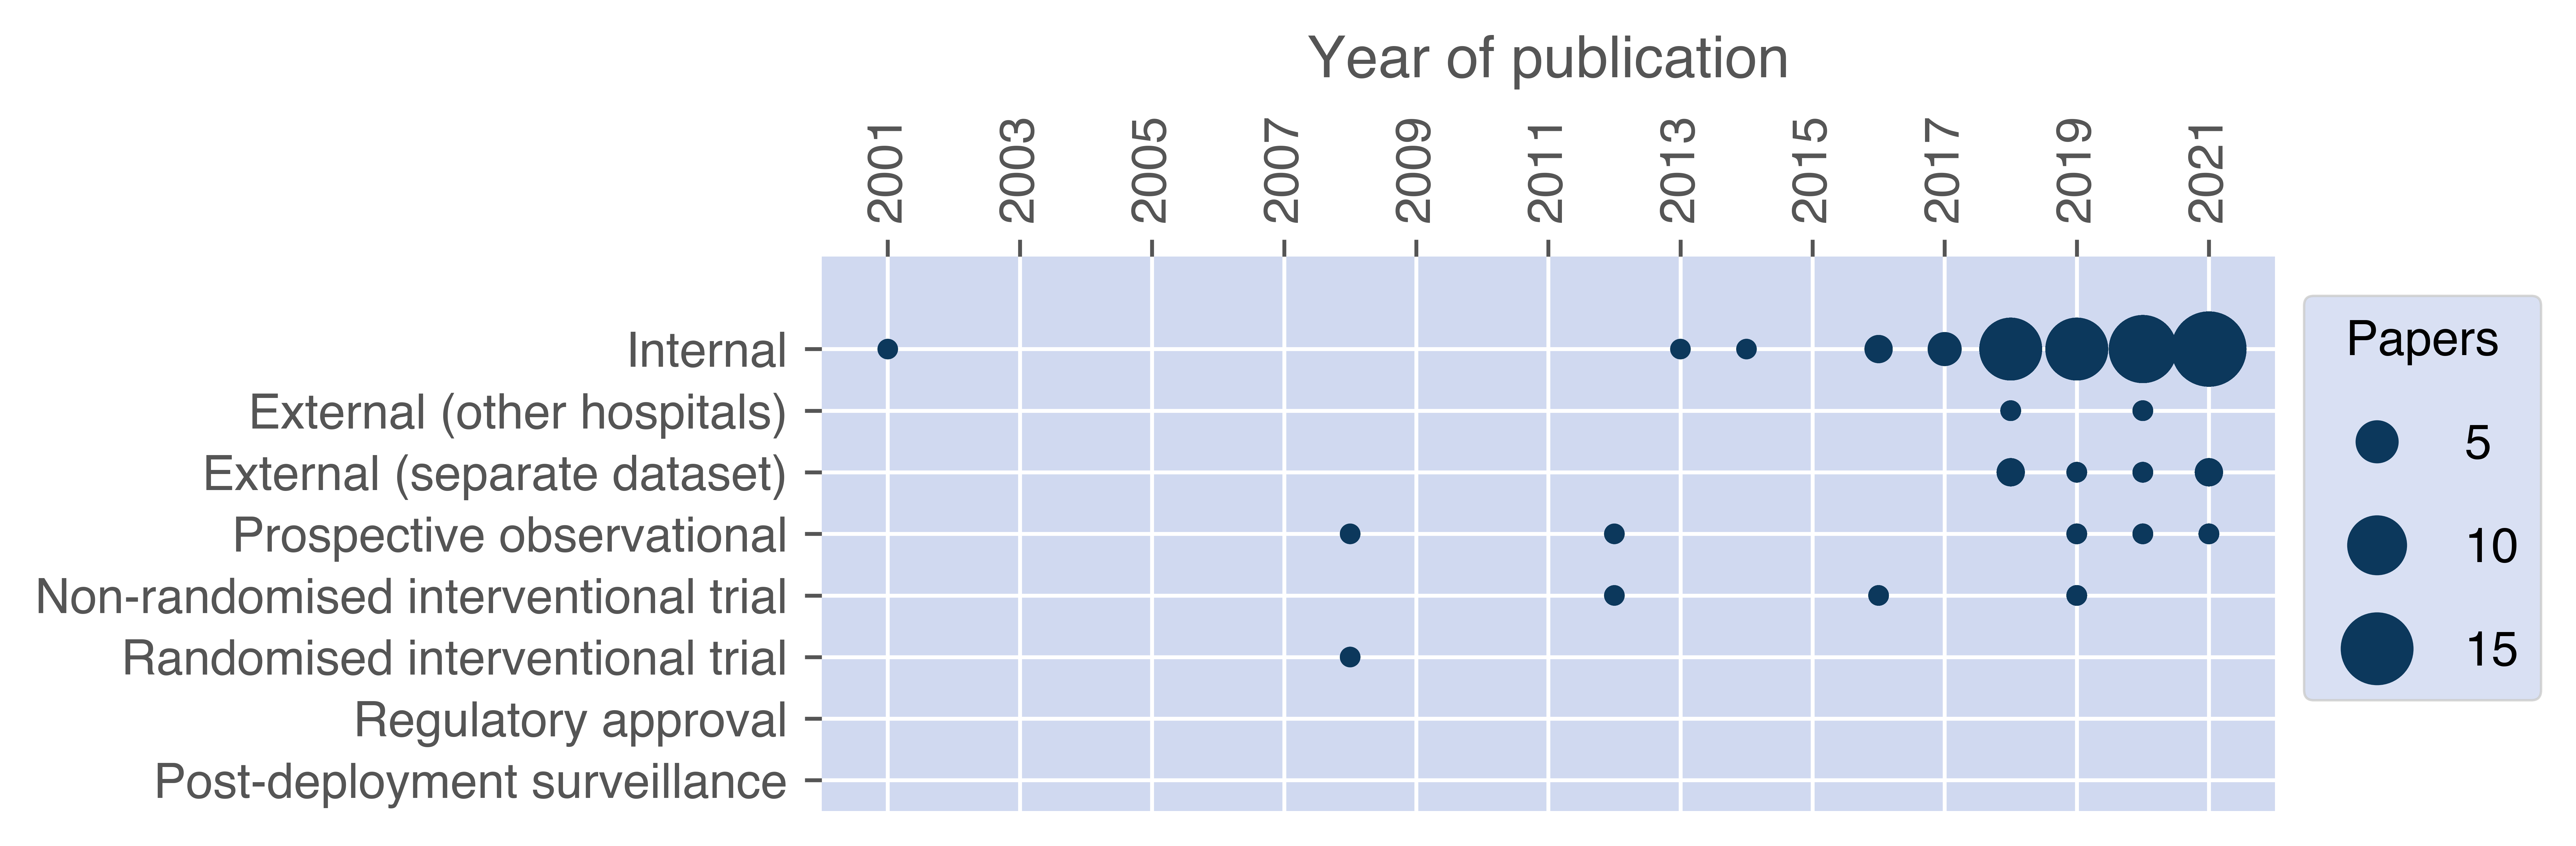

In [7]:
YEAR = "Year of publication"
VAL_TYPE = "validation"
validation_stages = [
    "Internal validation",
    "External retrospective validation (other hospitals)",
    "External retrospective validation (separate dataset)",
    "Prospective observational validation",
    "Non-randomised interventional validation (clinical trial)",
    "Randomised interventional validation (clinical trial)",
    "Regulatory approval",
    "Post-deployment surveillance"
]

tmp_df = papers_df.copy()

# Create a validation column with the name of the furthest stage of validation of each paper
tmp_df[VAL_TYPE] = [None for itr in range(len(papers_df))]
for row_idx in range(tmp_df.shape[0]):
    for val_stage in validation_stages:
        if tmp_df[val_stage][row_idx]:
            tmp_df.loc[row_idx, VAL_TYPE] = val_stage

#QOL functions
def get_papers_in_year_and_val(year, val):
    return tmp_df[(tmp_df[YEAR] == year) & (tmp_df[val])].shape[0]

def get_scatter_xyr(year, val):
    x = year - tmp_df[YEAR].min()
    y = validation_stages.index(val)
    r = tmp_df[(tmp_df[YEAR] == year) & (tmp_df[val])].shape[0]
    return x, y, r

# Data extraction
xs, ys, rs = [], [], []
R_SCALE = 14
for year in tmp_df[YEAR]:
    for val in validation_stages:
        x, y, r = get_scatter_xyr(year, val)
        xs.append(x)
        ys.append(y)
        rs.append(0 if r==0 else r*R_SCALE)

# Plot
with plt.rc_context({"axes.facecolor": "#D0D9F0"}):

    plt.figure(figsize=(7.5, 2.7))

    validation_stages_ticks = [
        "Internal",
        "External (other hospitals)",
        "External (separate dataset)",
        "Prospective observational",
        "Non-randomised interventional trial",
        "Randomised interventional trial",
        "Regulatory approval",
        "Post-deployment surveillance"
    ]

    scatter = plt.scatter(xs, ys, rs)

    handles, labels = scatter.legend_elements(
        prop="sizes", num=5, color=style_colors[0], func=lambda r: r/R_SCALE
    )
    plt.gca().legend(
        handles, labels, title="Papers",
        loc=(1.02, 0.2), borderpad=0.5, labelspacing=1.2
    )

    plt.xticks(list(range(0, 21, 2)), list(range(2001, 2022, 2)), rotation=90)
    plt.yticks(list(range(len(validation_stages))), validation_stages_ticks)
    plt.xlabel("Year of publication")
    plt.ylim(-1.5, 7.5)
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_coords(.5, 1.4)

    # Hide frame
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(os.path.join("out", f"Main - Bubble plot.png"))
    plt.savefig(os.path.join("out", f"Main - Bubble plot.svg"))

    plt.show()